In [1]:
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import mixture
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import pickle

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import numpy as np

### Read in Data

In [2]:
bd = pd.read_csv('./NNData_87.csv')
sd = pd.read_csv('./cfb22_nn_w1_w9.csv')

In [3]:
bd.shape

(4744, 88)

In [4]:
sd.shape

(459, 39)

In [5]:
sd = sd.dropna(axis=0)

In [6]:
sd.shape

(457, 39)

### Preprocess data to only numeric variables
- This allows us to perform PCA ICA later and standardize our comparison 
- Assumption: It does not matter what conference you play in, or, if the game is played in a neutral site

In [7]:
bd_target = bd[['home_team_cover_spread']]
sd_target = sd[['home_team_cover_spread']]

In [8]:
sd_target.shape

(457, 1)

In [9]:
bd = bd.drop(['Unnamed: 0','index', 'home_team_cover_spread'], axis=1)
sd = sd.drop(['Unnamed: 0', 'home_team_cover_spread'], axis=1)

In [10]:
bd = bd.drop(['year', 'home_conference_ACC', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt', 'neutral_site_False',
       'neutral_site_True'], axis = 1)

In [11]:
sd = sd.drop(['week', 'home_conference_ACC', 'home_conference_American Athletic',
       'home_conference_Big 12', 'home_conference_Big Ten',
       'home_conference_Conference USA', 'home_conference_FBS Independents',
       'home_conference_Mid-American', 'home_conference_Mountain West',
       'home_conference_Pac-12', 'home_conference_SEC',
       'home_conference_Sun Belt', 'away_conference_ACC',
       'away_conference_American Athletic', 'away_conference_Big 12',
       'away_conference_Big Ten', 'away_conference_Conference USA',
       'away_conference_FBS Independents', 'away_conference_Mid-American',
       'away_conference_Mountain West', 'away_conference_Pac-12',
       'away_conference_SEC', 'away_conference_Sun Belt', 'neutral_site_False',
       'neutral_site_True'],axis=1)

In [12]:
bd.columns

Index(['home_elo', 'away_elo', 'home_sp_plus', 'home_second_order_w',
       'home_sos', 'home_special_teams_rating', 'home_d_r_explosivenenss',
       'home_d_r_success', 'home_d_havoc_db', 'home_d_havoc_f7',
       'home_d_havoc_total', 'home_d_standardDowns', 'home_d_passing',
       'home_d_rushing', 'home_d_passingDowns', 'home_d_ranking',
       'home_o_r_explosiveness', 'home_o_r_success', 'home_o_standardDowns',
       'home_o_passing', 'home_o_rushing', 'home_o_runrate', 'home_o_pace',
       'home_o_passingDowns', 'home_o_ranking', 'away_sp_plus',
       'away_second_order_w', 'away_sos', 'away_special_teams_rating',
       'away_d_r_explosivenenss', 'away_d_r_success', 'away_d_havoc_db',
       'away_d_havoc_f7', 'away_d_havoc_total', 'away_d_standardDowns',
       'away_d_passing', 'away_d_rushing', 'away_d_passingDowns',
       'away_d_ranking', 'away_o_r_explosiveness', 'away_o_r_success',
       'away_o_standardDowns', 'away_o_passing', 'away_o_rushing',
       'away_o_r

In [13]:
sd.columns

Index(['home_elo', 'away_elo', 'spread', 'h_drives', 'h_d_explosiveness',
       'h_d_successrate', 'h_d_stuffrate', 'h_d_totalPPA', 'h_o_explosiveness',
       'h_o_successrate', 'h_o_stuffrate', 'h_o_totalPPA'],
      dtype='object')

# Clustering Experiments

### Classical K-Means - Big Dataset

In [14]:
centers = []
inertia = []
for i in range(1,25):
    km = cluster.KMeans(n_clusters=i, random_state=0).fit(bd)
    centers.append(km.cluster_centers_)
    inertia.append(km.inertia_)

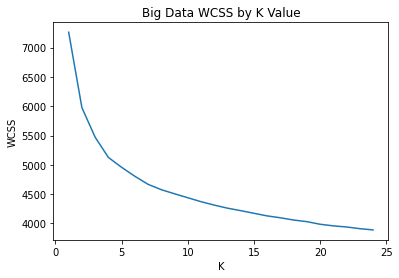

In [15]:
plt.title("Big Data WCSS by K Value")
plt.xlabel("K")
plt.ylabel("WCSS")
plt.plot(range(1,25),inertia)

In [16]:
# Let k = 4 via elbow method
km = cluster.KMeans(n_clusters=4, random_state=0).fit(bd)
labels = km.predict(bd)
len(labels)

4744

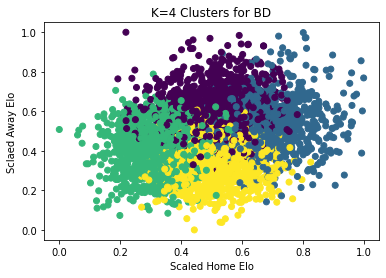

In [17]:
plt.title("K=4 Clusters for BD")
plt.xlabel("Scaled Home Elo")
plt.ylabel("Sclaed Away Elo")
plt.scatter(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'], c=labels)

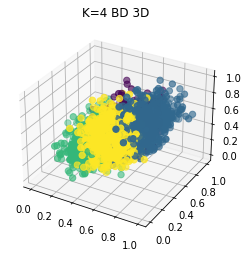

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("K=4 BD 3D")
ax.scatter3D(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'],bd.loc[:,'home_d_havoc_total'], c=labels, s=40, cmap='viridis')

In [19]:
# Let k = 4 via elbow method
km = cluster.KMeans(n_clusters=7, random_state=0).fit(bd)
labels = km.predict(bd)
len(labels)

4744

In [20]:
bdcentroid = km.cluster_centers_
bdcentroiddf = pd.DataFrame(bdcentroid, columns=bd.columns)
bdcentroiddf.var(axis=0).sort_values(ascending=False)

home_d_ranking               0.058007
home_o_ranking               0.052896
away_d_ranking               0.052517
away_o_ranking               0.048829
home_sp_plus                 0.028262
away_sp_plus                 0.028127
home_talent                  0.026367
home_sos                     0.025712
away_talent                  0.024249
home_second_order_w          0.022595
away_sos                     0.019235
home_elo                     0.016626
away_elo                     0.015894
home_d_passing               0.015172
home_d_r_success             0.013012
spread                       0.012647
away_second_order_w          0.012364
home_d_standardDowns         0.012038
home_d_havoc_total           0.011332
home_o_standardDowns         0.010271
home_o_r_success             0.009967
home_d_passingDowns          0.009001
home_o_passing               0.008288
away_d_passing               0.008228
home_o_rushing               0.007566
d_totalPPA                   0.007229
home_o_passi

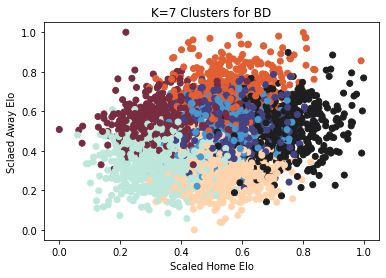

In [21]:
plt.title("K=7 Clusters for BD")
plt.xlabel("Scaled Home Elo")
plt.ylabel("Sclaed Away Elo")
plt.scatter(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'], c=labels, cmap='icefire')

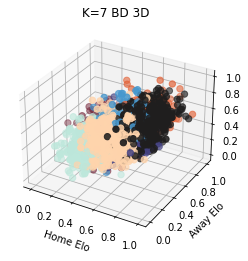

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("K=7 BD 3D")
plt.xlabel('Home Elo')
plt.ylabel("Away Elo")
ax.scatter3D(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'],bd.loc[:,'home_d_havoc_total'], c=labels, s=40, cmap='icefire')

In [23]:
# Let k = 4 via elbow method
km = cluster.KMeans(n_clusters=10, random_state=0).fit(bd)
labels = km.predict(bd)
len(labels)

4744

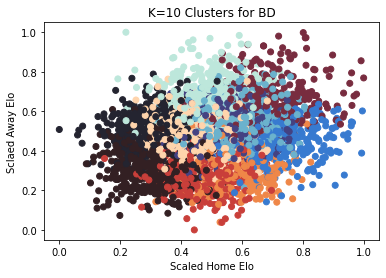

In [24]:
plt.title("K=10 Clusters for BD")
plt.xlabel("Scaled Home Elo")
plt.ylabel("Sclaed Away Elo")
plt.scatter(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'], c=labels, cmap='icefire')

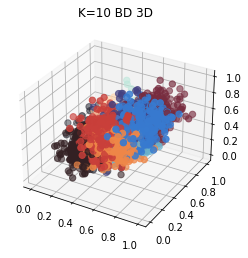

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("K=10 BD 3D")
ax.scatter3D(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'],bd.loc[:,'home_d_havoc_total'], c=labels, s=40, cmap='icefire')

## BD NN KM

In [26]:
# Let k = 4 via elbow method
km = cluster.KMeans(n_clusters=7, random_state=0).fit(bd)
labels = km.predict(bd)
labels

array([0, 5, 4, ..., 5, 2, 0])

In [27]:
bdkmcenters = pd.DataFrame(km.cluster_centers_, columns=bd.columns)
bdkmcenters['spread']

0    0.509599
1    0.474712
2    0.477197
3    0.345115
4    0.632018
5    0.600286
6    0.341243
Name: spread, dtype: float64

In [28]:
bdkmcenters.shape

(7, 60)

In [29]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7'])

In [30]:
bdkmnndf = pd.concat([bd,labelsdf2], axis=1)
bdkmnndf['target'] = bd_target
bdkmnndf.to_csv('bdkmnndf.csv')

In [31]:
trainx, testx, trainy, testy = train_test_split(bdkmnndf, bd_target, test_size=.3, random_state=42)

In [32]:
bdkmnn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [33]:
bdkmnn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [34]:
y_train_pred = bdkmnn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bdkmnn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  1.0
Test accuracy:  1.0


### Classical K-Means Clustering - Small Dataset

In [35]:
centers = []
inertia = []
for i in range(1,25):
    km = cluster.KMeans(n_clusters=i, random_state=0).fit(sd)
    centers.append(km.cluster_centers_)
    inertia.append(km.inertia_)

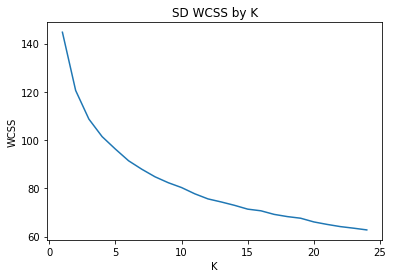

In [36]:
plt.title("SD WCSS by K")
plt.xlabel("K")
plt.ylabel("WCSS")
plt.plot(range(1,25),inertia)

In [37]:
# Let K = 4 via elbow method
km = cluster.KMeans(n_clusters=7, random_state=0).fit(sd)
labels = km.predict(sd)
len(labels)

457

In [38]:
sdcentroid = pd.DataFrame(km.cluster_centers_, columns=sd.columns)
sdcentroid.var(axis=0).sort_values(ascending=False)

spread               0.020362
h_d_totalPPA         0.020335
h_d_successrate      0.016683
home_elo             0.016432
h_o_stuffrate        0.015872
h_o_totalPPA         0.014531
h_o_successrate      0.014345
away_elo             0.013033
h_drives             0.008364
h_d_stuffrate        0.007343
h_d_explosiveness    0.005327
h_o_explosiveness    0.004887
dtype: float64

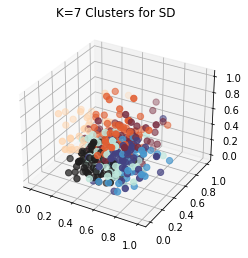

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("K=7 Clusters for SD")
ax.scatter3D(sd.iloc[:,2],sd.iloc[:,6],sd.iloc[:,3], c=labels, s=40, cmap='icefire')

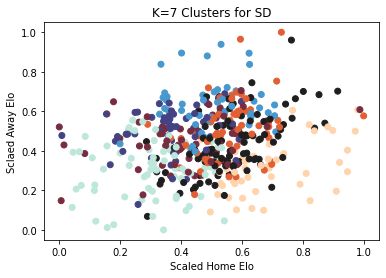

In [40]:
plt.title("K=7 Clusters for SD")
plt.xlabel("Scaled Home Elo")
plt.ylabel("Sclaed Away Elo")
plt.scatter(sd.loc[:,'home_elo'],sd.loc[:,'away_elo'], c=labels, cmap='icefire')

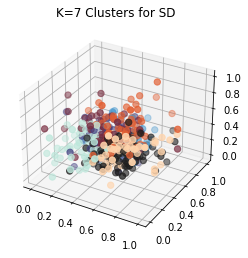

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("K=7 Clusters for SD")
ax.scatter3D(sd.loc[:,'home_elo'],sd.loc[:,'away_elo'],sd.iloc[:,3], c=labels, s=40, cmap='icefire')

## SD KM NN

In [42]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4','C5', 'C6', 'C7'])

In [43]:
sdkmnndf = pd.concat([sd.reset_index(),labelsdf2], axis=1)
sdkmnndf = sdkmnndf.drop('index', axis=1)
sdkmnndf

,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA,C1,C2,C3,C4,C5,C6,C7
0,0.363287,0.560706,0.755814,0.545455,0.525943,0.533939,0.189655,0.686762,0.328233,0.530378,0.304348,0.467733,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.466974,0.458425,0.447674,0.454545,0.311295,0.155642,0.295699,0.258220,0.173752,0.677011,0.333333,0.487121,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.520737,0.178808,0.331395,0.363636,0.504999,0.414200,0.545045,0.450794,0.252425,0.599884,0.208333,0.490175,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.362519,0.406181,0.627907,0.090909,0.430090,0.502117,0.329060,0.595901,0.366020,0.433870,0.148148,0.267459,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.227343,0.507726,0.691860,0.272727,0.260224,0.424010,0.333333,0.445528,0.360928,0.414189,0.250000,0.233661,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0.498464,0.345107,0.325581,0.272727,0.478934,0.328003,0.392857,0.441128,0.274292,0.558110,0.750000,0.420685,0.0,0.0,0.0,0.0,1.0,0.0,0.0
453,0.483103,0.403974,0.488372,0.272727,0.565888,0.602789,0.458333,0.741524,0.221948,0.617191,0.470588,0.280414,0.0,0.0,1.0,0.0,0.0,0.0,0.0
454,0.208909,0.397351,0.744186,0.363636,0.425106,0.601771,0.134146,0.678730,0.351512,0.410575,0.214286,0.323153,0.0,0.0,1.0,0.0,0.0,0.0,0.0
455,0.301075,0.306107,0.529070,0.545455,0.304514,0.528829,0.396396,0.601629,0.088698,0.547204,0.212766,0.291999,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
trainx, testx, trainy, testy = train_test_split(sdkmnndf, sd_target, test_size=.3, random_state=42)

In [45]:
sdkmnn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [46]:
sdkmnn.fit(trainx,trainy).fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [47]:
y_train_pred = sdkmnn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sdkmnn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.5768025078369906
Test accuracy:  0.5652173913043478


### GMM - Expectation Maximization - Big Dataset

In [48]:
# ~ 2 min
gmm_bic = []
gmm_aic = []
for i in range(1,25):
    gmm = mixture.GaussianMixture(n_components=i, random_state=0).fit(bd)
    gmm_bic.append(gmm.bic(bd))
    gmm_aic.append(gmm.aic(bd))

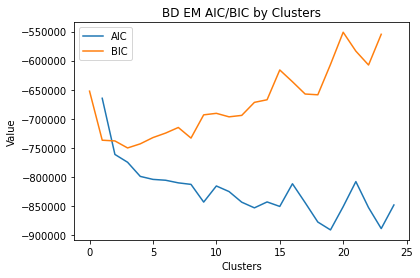

In [49]:
r = np.arange(1,25)
plt.plot(r, gmm_aic, gmm_bic)
plt.title("BD EM AIC/BIC by Clusters")
plt.xlabel('Clusters')
plt.ylabel('Value')
plt.legend(labels = ['AIC', 'BIC'])
plt.show()

In [50]:
# We will take AIC + BIC recommendation for simpler model and set K = 7
gmm = mixture.GaussianMixture(n_components=7).fit(bd)
print(gmm.converged_)

True


In [51]:
labels = gmm.predict(bd)
len(labels)

4744

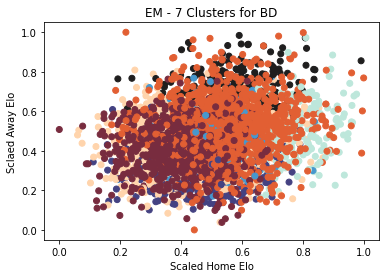

In [52]:
plt.title("EM - 7 Clusters for BD")
plt.xlabel("Scaled Home Elo")
plt.ylabel("Sclaed Away Elo")
plt.scatter(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'], c=labels, cmap='icefire')

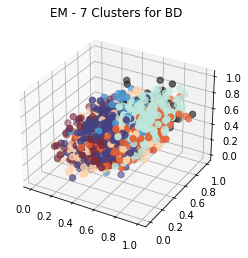

In [53]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("EM - 7 Clusters for BD")
ax.scatter3D(bd.loc[:,'home_elo'],bd.loc[:,'away_elo'],bd.loc[:,'home_d_havoc_total'], c=labels, s=40, cmap='icefire')

BD GM NN

In [54]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3','C4','C5', 'C6', 'C7'])

In [55]:
bdgmmnndf = pd.concat([bd,labelsdf2], axis=1)

In [56]:
trainx, testx, trainy, testy = train_test_split(bdgmmnndf, bd_target, test_size=.3, random_state=42)

In [57]:
bdgmmnn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [58]:
bdgmmnn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [59]:
y_train_pred = bdgmmnn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bdgmmnn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.811144578313253
Test accuracy:  0.7963483146067416


### GMM - Expectation Maximization - Small Dataset

In [60]:
# ~ 30s 
gmm_bic = []
gmm_aic = []
for i in range(1,25):
    gmm = mixture.GaussianMixture(n_components=i, random_state=0).fit(sd)
    gmm_bic.append(gmm.bic(sd))
    gmm_aic.append(gmm.aic(sd))

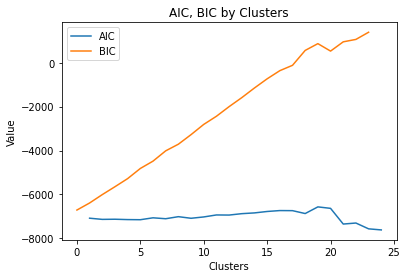

In [61]:
r = np.arange(1,25)
plt.plot(r, gmm_aic, gmm_bic)
plt.title("AIC, BIC by Clusters")
plt.xlabel('Clusters')
plt.ylabel('Value')
plt.legend(labels = ['AIC', 'BIC'])
plt.show()

In [62]:
# Even though AIC rises after 2, for comparison sake we will take AIC + BIC recommendation for simpler model and set K = 7. 
gmm = mixture.GaussianMixture(n_components=7).fit(sd)
print(gmm.converged_)

True


In [63]:
labels = gmm.predict(sd)
len(labels)

457

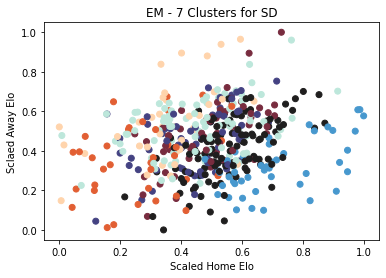

In [64]:
plt.title("EM - 7 Clusters for SD")
plt.xlabel("Scaled Home Elo")
plt.ylabel("Sclaed Away Elo")
plt.scatter(sd.loc[:,'home_elo'],sd.loc[:,'away_elo'], c=labels, cmap='icefire')

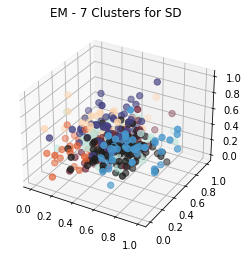

In [65]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("EM - 7 Clusters for SD")
ax.scatter3D(sd.loc[:,'home_elo'],sd.loc[:,'away_elo'],sd.iloc[:,3], c=labels, s=40, cmap='icefire')

In [66]:
cluster.

SyntaxError: invalid syntax (4100217796.py, line 1)

SD GMM NN

In [ ]:
labelsdf = pd.DataFrame(labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3','C4','C5', 'C6', 'C7'])

In [ ]:
sdgmmnndf = pd.concat([sd.reset_index(),labelsdf2], axis=1)
sdgmmnndf = sdgmmnndf.drop('index',axis=1)

In [ ]:
trainx, testx, trainy, testy = train_test_split(sdgmmnndf, sd_target, test_size=.3, random_state=42)

In [ ]:
sdgmmnn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
sdgmmnn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = sdgmmnn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sdgmmnn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.554858934169279
Test accuracy:  0.5797101449275363


#### As we can observe, these are pretty hard to visualize due to curse of dimensionality. So, we will employ DR techniques to see if we can condense the datasets.
#### This will be interesting to see which variables are selected from BD vs. the smaller SD.

## Create Baseline NNs with no dimension reduction to compare to rest of models 

In [ ]:
trainx, testx, trainy, testy = train_test_split(bd, bd_target, test_size=.3, random_state=42)

In [ ]:
bdnn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
bdnn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = bdnn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bdnn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.811144578313253
Test accuracy:  0.8033707865168539


In [ ]:
trainx, testx, trainy, testy = train_test_split(sd, sd_target, test_size=.3, random_state=42)

In [ ]:
sdnn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
sdnn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = sdnn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sdnn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.5078369905956113
Test accuracy:  0.4855072463768116


## Dimensionality Reduction

### - Bad news: PCA isn't advisable for categorical variables, which there are many in our data.
### - Good news: Our feature importance plots indicate that these variables are not very impactful on model performance.

### PCA - Big Dataset

In [ ]:
# create new dataframes to use here
bd_num = bd.copy()
sd_num = sd.copy()

In [ ]:
bd_num.shape

(4744, 60)

In [ ]:
bdpca2 = PCA(n_components=2)
bdpca3 = PCA(n_components=3)

In [ ]:
bdpca2.fit(bd_num)
bd_num_pca2 = bdpca2.fit_transform(bd_num)
print("original shape:   ", bd_num.shape)
print("transformed shape:", bd_num_pca2.shape)
print("explained variance:",bdpca2.explained_variance_)
dataset_pca = pd.DataFrame(abs(bdpca2.components_), columns=bd_num.columns, index=['PC_1', 'PC_2'])
dataset_pca

original shape:    (4744, 60)
transformed shape: (4744, 2)
explained variance: [0.40597635 0.25940071]


,home_elo,away_elo,home_sp_plus,home_second_order_w,home_sos,home_special_teams_rating,home_d_r_explosivenenss,home_d_r_success,home_d_havoc_db,home_d_havoc_f7,...,drives,d_explosiveness,d_successrate,d_stuffrate,d_totalPPA,o_explosiveness,o_successrate,o_stuffrate,o_totalPPA,spread
PC_1,0.190735,0.125573,0.248252,0.200290,0.239266,0.093039,0.083544,0.151492,0.092938,0.097976,...,0.000330,0.002488,0.022921,0.025562,0.038992,0.006440,0.032971,0.011429,0.026475,0.047581
PC_2,0.101847,0.194577,0.136850,0.183616,0.048732,0.040590,0.030395,0.107333,0.083736,0.077668,...,0.001185,0.002761,0.094415,0.054449,0.152234,0.007627,0.147162,0.062302,0.147442,0.220264


In [ ]:
print("\n**** BD Most important features ****")
print('From PC 1:\n', (dataset_pca[dataset_pca > 0.20].iloc[0]).dropna().sort_values(ascending=False))   
print('\n\nFrom PC 2:\n', (dataset_pca[dataset_pca > 0.20].iloc[1]).dropna().sort_values(ascending=False))
print("\n*******************************")


**** BD Most important features ****
From PC 1:
 home_d_ranking         0.337191
home_o_ranking         0.302440
home_sp_plus           0.248252
home_talent            0.245784
home_sos               0.239266
away_d_ranking         0.224537
away_o_ranking         0.205601
away_sos               0.202599
home_second_order_w    0.200290
Name: PC_1, dtype: float64


From PC 2:
 away_d_ranking         0.354985
away_o_ranking         0.337031
away_sp_plus           0.265347
spread                 0.220264
away_second_order_w    0.208475
Name: PC_2, dtype: float64

*******************************


In [ ]:
bdpca3.fit(bd_num)
bd_num_pca3 = bdpca3.fit_transform(bd_num)
print("original shape:   ", bd_num.shape)
print("transformed shape:", bd_num_pca3.shape)
print("explained variance:", bdpca3.explained_variance_)
print("components:", len(bdpca3.components_))

original shape:    (4744, 60)
transformed shape: (4744, 3)
explained variance: [0.40597635 0.25940071 0.11369195]
components: 3


In [ ]:
bdpd2 = pd.DataFrame(bd_num_pca2, columns=["comp1", "comp2"])
bdpd2['target'] = bd_target
bdpd2

,comp1,comp2,target
0,-1.263700,-0.052519,0
1,0.361504,0.689287,1
2,-0.150702,0.448274,1
3,0.130921,0.496711,0
4,0.766567,0.521025,1
...,...,...,...
4739,1.835105,0.021702,1
4740,0.339933,0.472672,0
4741,0.630356,0.516031,0
4742,0.045854,0.123695,1


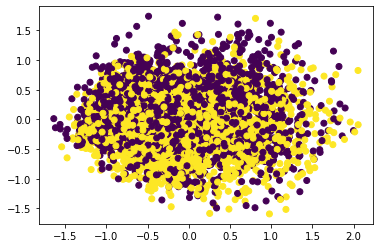

In [ ]:
# Visualize in 2D
plt.scatter(bdpd2['comp1'], bdpd2['comp2'], c = bdpd2['target'])

In [ ]:
bdpd3 = pd.DataFrame(bd_num_pca3, columns=["comp1", "comp2", "comp3"])
bdpd3['target'] = bd_target
bdpd3

,comp1,comp2,comp3,target
0,-1.263700,-0.052519,0.388587,0
1,0.361504,0.689287,-0.504334,1
2,-0.150702,0.448274,-0.020050,1
3,0.130921,0.496711,0.575396,0
4,0.766567,0.521025,0.627206,1
...,...,...,...,...
4739,1.835105,0.021702,0.058035,1
4740,0.339933,0.472672,-0.085477,0
4741,0.630356,0.516031,0.432211,0
4742,0.045854,0.123695,-0.064476,1


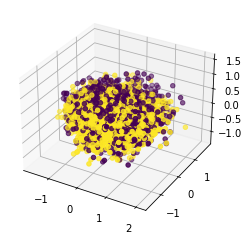

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(bdpd3['comp1'], bdpd3['comp2'], bdpd3['comp3'],c=bdpd3['target'])

### PCA - Small Dataset

In [ ]:
sdpca2 = PCA(n_components=2)
sdpca3 = PCA(n_components=3)

In [ ]:
sdpca2.fit(sd_num)
sd_num_pca2 = sdpca2.transform(sd_num)
print("original shape:   ", sd_num.shape)
print("transformed shape:", sd_num_pca2.shape)
print("explained variance:", sdpca2.explained_variance_)
dataset_pca = pd.DataFrame(abs(sdpca2.components_), columns=sd_num.columns, index=['PC_1', 'PC_2'])
dataset_pca

original shape:    (457, 12)
transformed shape: (457, 2)
explained variance: [0.08487138 0.0591091 ]


,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA
PC_1,0.358897,0.228957,0.492850,0.005401,0.013761,0.306026,0.077036,0.319366,0.079534,0.398096,0.230809,0.394957
PC_2,0.054932,0.084777,0.053063,0.352659,0.015516,0.419873,0.381404,0.460157,0.107534,0.314062,0.368357,0.288059


In [ ]:
print("\n**** SD Most important features ****")
print('From PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna().sort_values(ascending=False))   
print('\n\nFrom PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna().sort_values(ascending=False))
print("\n*******************************")


**** SD Most important features ****
From PC 1:
 spread             0.492850
h_o_successrate    0.398096
h_o_totalPPA       0.394957
home_elo           0.358897
h_d_totalPPA       0.319366
h_d_successrate    0.306026
Name: PC_1, dtype: float64


From PC 2:
 h_d_totalPPA       0.460157
h_d_successrate    0.419873
h_d_stuffrate      0.381404
h_o_stuffrate      0.368357
h_drives           0.352659
h_o_successrate    0.314062
Name: PC_2, dtype: float64

*******************************


In [ ]:
sdpca3.fit(sd_num)
sd_num_pca3 = sdpca3.transform(sd_num)
print("original shape:   ", sd_num.shape)
print("transformed shape:", sd_num_pca3.shape)
print("explained variance:", sdpca3.explained_variance_)
dataset_pca = pd.DataFrame(abs(sdpca3.components_), columns=sd_num.columns, index=['PC_1', 'PC_2','PC_3'])
dataset_pca

original shape:    (457, 12)
transformed shape: (457, 3)
explained variance: [0.08487138 0.0591091  0.03703906]


,home_elo,away_elo,spread,h_drives,h_d_explosiveness,h_d_successrate,h_d_stuffrate,h_d_totalPPA,h_o_explosiveness,h_o_successrate,h_o_stuffrate,h_o_totalPPA
PC_1,0.358897,0.228957,0.492850,0.005401,0.013761,0.306026,0.077036,0.319366,0.079534,0.398096,0.230809,0.394957
PC_2,0.054932,0.084777,0.053063,0.352659,0.015516,0.419873,0.381404,0.460157,0.107534,0.314062,0.368357,0.288059
PC_3,0.570134,0.662801,0.090419,0.117535,0.292122,0.015936,0.238726,0.153117,0.071228,0.060622,0.176279,0.088346


In [ ]:
print("\n**** Most important features ****")
print('From PC 1:\n', (dataset_pca[dataset_pca > 0.3].iloc[0]).dropna())   
print('\n\nFrom PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n*******************************")


*************** Most important features *************************
As per PC 1:
 home_elo           0.358897
spread             0.492850
h_d_successrate    0.306026
h_d_totalPPA       0.319366
h_o_successrate    0.398096
h_o_totalPPA       0.394957
Name: PC_1, dtype: float64


As per PC 2:
 h_drives           0.352659
h_d_successrate    0.419873
h_d_stuffrate      0.381404
h_d_totalPPA       0.460157
h_o_successrate    0.314062
h_o_stuffrate      0.368357
Name: PC_2, dtype: float64


As per PC 3:
 home_elo    0.570134
away_elo    0.662801
Name: PC_3, dtype: float64

******************************************************************


In [ ]:
sdpd2 = pd.DataFrame(sd_num_pca2, columns=["comp1", "comp2"])
sdpd2['target'] = sd_target
sdpd2

,comp1,comp2,target
0,-0.227276,-0.132247,1.0
1,0.314204,0.197256,1.0
2,0.328680,0.072797,0.0
3,-0.167884,-0.128263,0.0
4,-0.244554,0.090423,0.0
...,...,...,...
452,0.131532,0.246185,0.0
453,-0.104704,-0.083282,1.0
454,-0.350249,-0.169212,0.0
455,-0.060449,0.014238,1.0


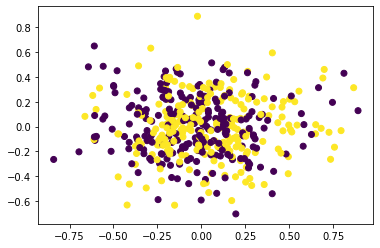

In [ ]:
# Visualize in 2D
plt.scatter(sdpd2['comp1'], sdpd2['comp2'], c = sdpd2['target'])

In [ ]:
sdpd3 = pd.DataFrame(sd_num_pca3, columns=["comp1", "comp2", "comp3"])
sdpd3['target'] = sd_target
sdpd3

,comp1,comp2,comp3,target
0,-0.227276,-0.132247,0.077454,1.0
1,0.314204,0.197256,-0.062037,1.0
2,0.328680,0.072797,-0.117275,0.0
3,-0.167884,-0.128263,-0.146907,0.0
4,-0.244554,0.090423,-0.186488,0.0
...,...,...,...,...
452,0.131532,0.246185,0.013357,0.0
453,-0.104704,-0.083282,0.079191,1.0
454,-0.350249,-0.169212,-0.220528,0.0
455,-0.060449,0.014238,-0.223260,1.0


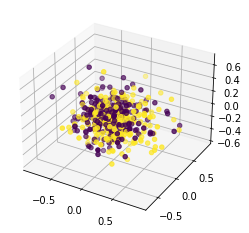

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(sdpd3['comp1'], sdpd3['comp2'], sdpd3['comp3'],c=sdpd3['target'])

#### Small Data looks a lot less noisy at first glance. We see a "left/right" split in the 2D plot. We see a "north/south" split in the Big Data 2D plot.
 However the variance explained is much greater in the big dataset.

### Choosing number of components

Text(0, 0.5, 'cumulative explained variance')

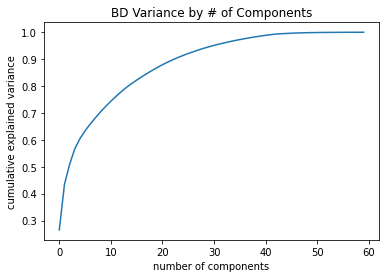

In [ ]:
pca = PCA().fit(bd_num)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('BD Variance by # of Components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Text(0, 0.5, 'cumulative explained variance')

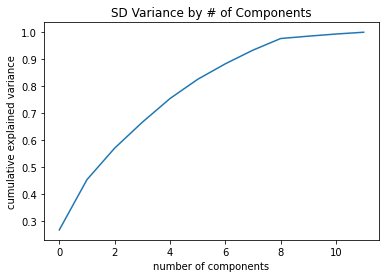

In [ ]:
pca = PCA().fit(sd_num)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('SD Variance by # of Components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

- Here we see the two-dimensional representation of both datasets results in missing a lot of information contained in the data. It is nice to visualize them, but for performance, we really should include more components.
- The big data set has a lot more room for dimensionality reduction than the small data set. These plots prove that.
- We can restructure the datasets now using reduced #s of features. To stay above 90% variance explained, big data can be projected down to 25. Small data can be projected down to 8

## Clustering the PCA reduced data

### PCA Big data - KMeans first

In [ ]:
bdpca25 = PCA(n_components=25)

In [ ]:
bdpca25.fit(bd_num)
bd_num_pca25 = bdpca25.transform(bd_num)
print("original shape:   ", bd_num.shape)
print("transformed shape:", bd_num_pca25.shape)
print("explained variance:", bdpca25.explained_variance_ratio_.cumsum())

original shape:    (4744, 60)
transformed shape: (4744, 25)
explained variance: [0.26514088 0.43455403 0.5088056  0.5665261  0.60437907 0.63366076
 0.65890668 0.68186546 0.70409824 0.72435313 0.74381794 0.76164559
 0.7788086  0.7947401  0.80901536 0.82190774 0.8347562  0.84654808
 0.85794686 0.86903484 0.87925888 0.8888399  0.89766853 0.90604393
 0.91374371]


In [ ]:
bd25 = pd.DataFrame(bd_num_pca25)
bd25.head(1)
# bd25['target'] = bd_target

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.2637,-0.052519,0.388592,0.009554,0.581781,0.054004,-0.268035,-0.228576,-0.28628,-0.088508,...,0.151844,0.124553,0.345351,-0.116316,-0.051198,-0.057062,0.210261,0.174863,-0.08173,0.332136


In [ ]:
centers = []
inertia = []
for i in range(1,25):
    km = cluster.KMeans(n_clusters=i, random_state=0).fit(bd25)
    centers.append(km.cluster_centers_)
    inertia.append(km.inertia_)

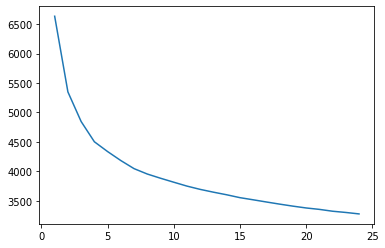

In [ ]:
plt.plot(range(1,25),inertia)

In [ ]:
kmeansbd25 = cluster.KMeans(n_clusters=7)
kmeansbd25.fit(bd25)
y_kmeans = kmeansbd25.predict(bd25)

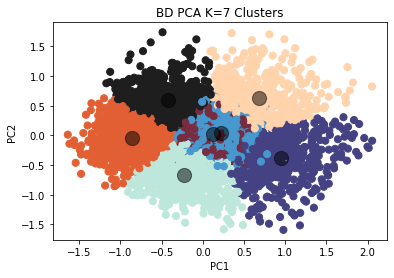

In [ ]:
plt.scatter(bd25.iloc[:, 0], bd25.iloc[:, 1], c=y_kmeans, s=50, cmap='icefire')
plt.title("BD PCA K=7 Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
centers = kmeansbd25.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
# # Let K = 4 via elbow method
# km = cluster.KMeans(n_clusters=4, random_state=0).fit(bd25)
# labels = km.predict(sd)
# len(labels)

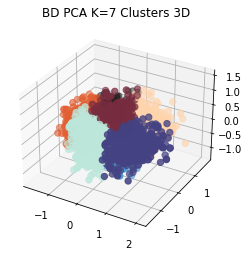

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("BD PCA K=7 Clusters 3D")
ax.scatter3D(bd25.iloc[:,0],bd25.iloc[:,1],bd25.iloc[:,2], c=y_kmeans, s=40, cmap='icefire')

## PCA Small Data - Kmeans

In [ ]:
sdpca8 = PCA(n_components=8)

In [ ]:
sdpca8.fit(sd_num)
sd_num_pca8 = sdpca8.transform(sd_num)
print("original shape:   ", sd_num.shape)
print("transformed shape:", sd_num_pca8.shape)
print("explained variance:", sdpca8.explained_variance_ratio_.cumsum())

original shape:    (457, 12)
transformed shape: (457, 8)
explained variance: [0.26747593 0.4537609  0.57049116 0.66641848 0.75423644 0.82549043
 0.88299521 0.93368977]


In [ ]:
sd8 = pd.DataFrame(sd_num_pca8)
sd8.head(1)

,0,1,2,3,4,5,6,7
0,-0.227276,-0.132247,0.077454,-0.155967,0.109178,-0.184598,-0.079801,0.053005


In [ ]:
centers = []
inertia = []
for i in range(1,25):
    km = cluster.KMeans(n_clusters=i, random_state=0).fit(sd8)
    centers.append(km.cluster_centers_)
    inertia.append(km.inertia_)

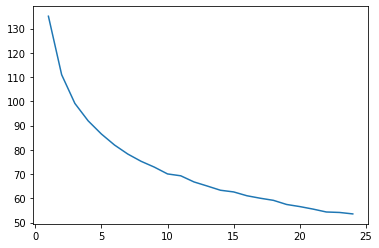

In [ ]:
plt.plot(range(1,25),inertia)

In [ ]:
kmeanssd8 = cluster.KMeans(n_clusters=7)
kmeanssd8.fit(sd8)
y_kmeans = kmeanssd8.predict(sd8)

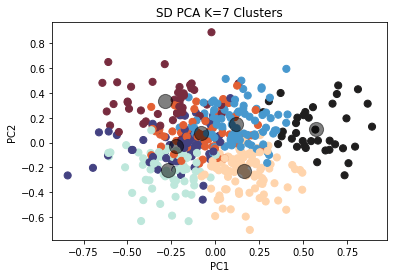

In [ ]:
plt.scatter(sd8.iloc[:, 0], sd8.iloc[:, 1], c=y_kmeans, s=50, cmap='icefire')
plt.title("SD PCA K=7 Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
centers = kmeanssd8.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

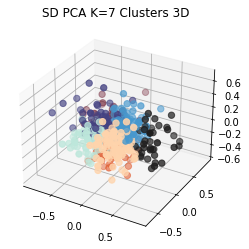

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.title("SD PCA K=7 Clusters 3D")
ax.scatter3D(sd8.iloc[:,0],sd8.iloc[:,1],sd8.iloc[:,2], c=y_kmeans, s=40, cmap='icefire')

## PCA Big Data GMM

In [ ]:
# ~ 2 min
gmm_bic = []
gmm_aic = []
for i in range(1,25):
    gmm = mixture.GaussianMixture(n_components=i, random_state=0).fit(bd25)
    gmm_bic.append(gmm.bic(bd25))
    gmm_aic.append(gmm.aic(bd25))

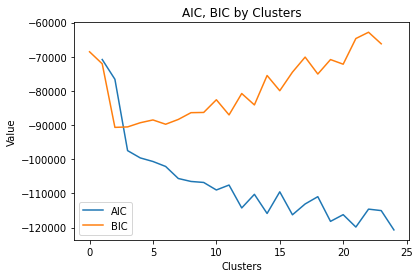

In [ ]:
r = np.arange(1,25)
plt.plot(r, gmm_aic, gmm_bic)
plt.title("AIC, BIC by Clusters")
plt.xlabel('Clusters')
plt.ylabel('Value')
plt.legend(labels = ['AIC', 'BIC'])
plt.show()

In [ ]:
# We will take AIC + BIC recommendation for simpler model and set K = 7
gmm = mixture.GaussianMixture(n_components=7).fit(bd25)
bdgmmlabels = gmm.predict(bd25)
print(gmm.converged_)

True


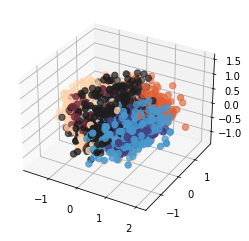

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(bd25.iloc[:,0],bd25.iloc[:,1] ,bd25.iloc[:,2], c=bdgmmlabels, s=40, cmap='icefire')

### PCA Small Data GMM

In [ ]:
# ~ 30s 
gmm_bic = []
gmm_aic = []
for i in range(1,25):
    gmm = mixture.GaussianMixture(n_components=i, random_state=0).fit(sd8)
    gmm_bic.append(gmm.bic(sd8))
    gmm_aic.append(gmm.aic(sd8))

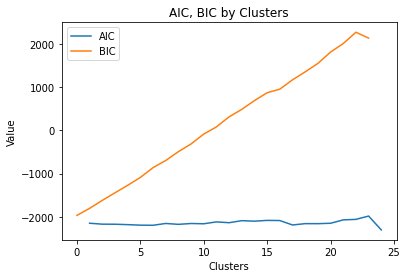

In [ ]:
r = np.arange(1,25)
plt.plot(r, gmm_aic, gmm_bic)
plt.title("AIC, BIC by Clusters")
plt.xlabel('Clusters')
plt.ylabel('Value')
plt.legend(labels = ['AIC', 'BIC'])
plt.show()

In [ ]:
# Even though AIC rises after 2, for comparison sake we will take AIC + BIC recommendation for simpler model and set K = 7. 
gmm = mixture.GaussianMixture(n_components=7).fit(sd8)
print(gmm.converged_)

True


In [ ]:
sdgmmlabels = gmm.predict(sd8)
len(labels)

457

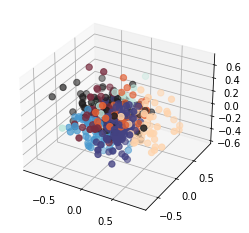

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(sd8.iloc[:,0],sd8.iloc[:,1],sd8.iloc[:,2], c=sdgmmlabels, s=40, cmap='icefire')

## Retrain NN

### Since some of the data sets have different dimensions and variables, a new NN will be trained for each data set using the same method from assignment 1

#### Big data PCA NN

In [ ]:
bd25.shape

(4744, 25)

In [ ]:
bd_target.shape

(4744, 1)

In [ ]:
trainx, testx, trainy, testy = train_test_split(bd25, bd_target, test_size=.3, random_state=42)

In [ ]:
bd_pca_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
bd_pca_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
# Predict labels for train set and assess accuracy
y_train_pred = bd_pca_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bd_pca_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.766867469879518
Test accuracy:  0.7464887640449438


### Small Data PCA NN

In [ ]:
sd8.shape

(457, 8)

In [ ]:
sd_target.shape

(457, 1)

In [ ]:
trainx, testx, trainy, testy = train_test_split(sd8, sd_target, test_size=.3, random_state=42)

In [ ]:
sd_pca_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
sd_pca_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
# Predict labels for train set and assess accuracy
y_train_pred = sd_pca_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sd_pca_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.5203761755485894
Test accuracy:  0.5652173913043478


## Kmeans Clustered PCA BD NN Using clusters as features

In [ ]:

kmbd25 = bd25.copy()
kmbd25labels = kmeansbd25.labels_
kmbd25labels

array([1, 3, 3, ..., 3, 3, 0])

In [ ]:
labelsdf = pd.DataFrame(kmbd25labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4'])


In [ ]:
kmbd25nn = pd.concat([kmbd25,labelsdf2], axis=1)
kmbd25nn

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,C1,C2,C3,C4
0,-1.263700,-0.052519,0.388592,0.009554,0.581781,0.054001,-0.268024,-0.228581,-0.286268,-0.088479,...,-0.050991,-0.058555,0.208946,0.173101,-0.081344,0.337290,0.0,1.0,0.0,0.0
1,0.361504,0.689287,-0.504326,-0.288128,0.310294,0.230363,0.068117,-0.045888,-0.009356,0.121519,...,0.064816,0.137119,0.014639,0.003234,0.103632,0.084802,0.0,0.0,0.0,1.0
2,-0.150702,0.448274,-0.020053,-0.309940,-0.107777,-0.114211,0.269024,0.119730,0.079160,0.076309,...,-0.219342,-0.056796,-0.034070,-0.110121,-0.066955,-0.052421,0.0,0.0,0.0,1.0
3,0.130921,0.496711,0.575399,-0.865417,-0.071418,0.466252,-0.226118,0.203971,-0.127550,-0.109847,...,0.209314,-0.102254,0.181260,-0.077537,0.029530,0.207202,0.0,0.0,0.0,1.0
4,0.766567,0.521025,0.627206,-0.130469,-0.049623,0.226450,-0.219446,-0.220070,-0.093284,-0.087957,...,-0.035306,0.204337,0.072742,0.005472,0.075368,0.120488,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,1.835105,0.021702,0.058029,-0.181237,-0.174759,-0.456187,0.016934,0.031521,0.078457,0.157376,...,0.064189,0.083007,0.000314,-0.034676,0.205043,0.158256,0.0,0.0,1.0,0.0
4740,0.339933,0.472672,-0.085470,0.022700,0.093110,-0.109330,-0.248287,0.038024,0.001499,-0.330586,...,0.189420,0.036380,-0.046065,-0.052207,-0.022977,-0.172145,0.0,0.0,0.0,1.0
4741,0.630356,0.516031,0.432211,-0.136123,0.041300,-0.270391,0.224650,-0.365140,-0.013740,-0.073558,...,-0.014273,0.129938,0.043061,-0.100528,0.016372,-0.152783,0.0,0.0,0.0,1.0
4742,0.045854,0.123695,-0.064474,-0.219974,0.302664,0.115355,0.166467,0.100072,-0.002907,0.022948,...,-0.171880,0.154029,0.082993,-0.114329,-0.115622,-0.004911,0.0,0.0,0.0,1.0


In [ ]:
trainx, testx, trainy, testy = train_test_split(kmbd25nn, bd_target, test_size=.3, random_state=42)

In [ ]:
bd_km_pca_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
bd_km_pca_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = bd_km_pca_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bd_km_pca_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.7710843373493976
Test accuracy:  0.7401685393258427


## GMM Clustered PCA BD NN Using clusters as features

In [ ]:
gmmbd25 = bd25.copy()
gmmbd25labels = bdgmmlabels
gmmbd25labels.max()

6

In [ ]:
labelsdf = pd.DataFrame(gmmbd25labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])

In [ ]:
bd_gmm_pca_nn_df = pd.concat([bd25,labelsdf2], axis=1)
bd_gmm_pca_nn_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,C1,C2,C3,C4,C5,C6,C7
0,-1.263700,-0.052519,0.388592,0.009554,0.581781,0.054001,-0.268024,-0.228581,-0.286268,-0.088479,...,0.173101,-0.081344,0.337290,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.361504,0.689287,-0.504326,-0.288128,0.310294,0.230363,0.068117,-0.045888,-0.009356,0.121519,...,0.003234,0.103632,0.084802,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.150702,0.448274,-0.020053,-0.309940,-0.107777,-0.114211,0.269024,0.119730,0.079160,0.076309,...,-0.110121,-0.066955,-0.052421,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.130921,0.496711,0.575399,-0.865417,-0.071418,0.466252,-0.226118,0.203971,-0.127550,-0.109847,...,-0.077537,0.029530,0.207202,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.766567,0.521025,0.627206,-0.130469,-0.049623,0.226450,-0.219446,-0.220070,-0.093284,-0.087957,...,0.005472,0.075368,0.120488,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,1.835105,0.021702,0.058029,-0.181237,-0.174759,-0.456187,0.016934,0.031521,0.078457,0.157376,...,-0.034676,0.205043,0.158256,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4740,0.339933,0.472672,-0.085470,0.022700,0.093110,-0.109330,-0.248287,0.038024,0.001499,-0.330586,...,-0.052207,-0.022977,-0.172145,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4741,0.630356,0.516031,0.432211,-0.136123,0.041300,-0.270391,0.224650,-0.365140,-0.013740,-0.073558,...,-0.100528,0.016372,-0.152783,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4742,0.045854,0.123695,-0.064474,-0.219974,0.302664,0.115355,0.166467,0.100072,-0.002907,0.022948,...,-0.114329,-0.115622,-0.004911,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
trainx, testx, trainy, testy = train_test_split(bd_gmm_pca_nn_df, bd_target, test_size=.3, random_state=42)
trainx

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,C1,C2,C3,C4,C5,C6,C7
108,0.884570,-0.307692,-0.496950,0.092642,0.250941,-0.447492,0.157769,0.069352,0.018734,0.035865,...,0.048580,-0.010174,-0.101767,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2121,0.339906,0.579045,-0.400110,-0.326299,0.354442,0.315394,0.239774,0.006252,-0.379539,0.115579,...,0.115000,0.210362,0.052502,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1564,0.275893,0.983034,-0.139354,0.090007,-0.086883,0.238713,-0.270971,-0.383920,0.231381,0.024870,...,-0.185834,-0.108636,0.068952,0.0,0.0,0.0,0.0,0.0,1.0,0.0
58,-1.257732,-0.269182,-0.311845,-0.302129,0.257800,-0.049425,-0.064691,-0.030011,-0.118218,0.004513,...,0.038607,-0.120506,-0.056923,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76,-1.049000,0.346796,-0.355537,0.297115,-0.129072,0.184314,-0.022157,0.091719,0.036493,0.273097,...,0.056363,0.421473,-0.125404,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.146857,-0.041375,-0.122623,-0.047494,0.072339,-0.070928,-0.005959,-0.072798,0.176646,0.304443,...,-0.064993,0.031045,-0.142249,0.0,0.0,1.0,0.0,0.0,0.0,0.0
466,0.783499,0.648250,-0.189111,-0.456061,-0.055538,0.127174,-0.230758,-0.041159,0.086748,0.148843,...,-0.148368,-0.001918,-0.145458,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3092,-0.936281,0.174585,-0.198273,0.015387,-0.129213,0.184813,-0.103605,0.027905,-0.195655,0.051444,...,-0.089759,0.005371,0.039780,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3772,0.198760,0.405453,0.261250,0.047570,0.158383,-0.066106,-0.051363,-0.274402,-0.092906,-0.202217,...,0.035866,0.055691,0.031355,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
bd_gmm_pca_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
bd_gmm_pca_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = bd_gmm_pca_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = bd_gmm_pca_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.7551204819277109
Test accuracy:  0.7310393258426966


## Kmeans Clustered PCA SD NN Using clusters as features

In [ ]:
kmsd8 = sd8.copy()
kmsd8labels = kmeanssd8.labels_
kmsd8labels.max()

3

In [ ]:
labelsdf = pd.DataFrame(kmsd8labels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4'])

In [ ]:
sd_km_pca_nn_df = pd.concat([sd8,labelsdf2], axis=1)
sd_km_pca_nn_df

,0,1,2,3,4,5,6,7,C1,C2,C3,C4
0,-0.227276,-0.132247,0.077454,-0.155967,0.109178,-0.184598,-0.079801,0.053005,0.0,1.0,0.0,0.0
1,0.314204,0.197256,-0.062037,-0.116507,-0.159211,0.030206,-0.072824,0.083980,1.0,0.0,0.0,0.0
2,0.328680,0.072797,-0.117275,-0.114929,0.171570,0.063868,0.083978,-0.144463,1.0,0.0,0.0,0.0
3,-0.167884,-0.128263,-0.146907,-0.111630,0.008606,0.166583,0.040499,0.112190,0.0,1.0,0.0,0.0
4,-0.244554,0.090423,-0.186488,-0.099118,-0.124060,0.100624,-0.137923,0.096119,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
452,0.131532,0.246185,0.013357,0.191016,0.135817,0.227943,0.223669,0.003832,0.0,0.0,0.0,1.0
453,-0.104704,-0.083282,0.079191,-0.030072,0.173136,0.162719,0.232895,-0.193368,0.0,1.0,0.0,0.0
454,-0.350249,-0.169212,-0.220528,-0.124290,0.060940,-0.103808,-0.022859,0.086818,0.0,1.0,0.0,0.0
455,-0.060449,0.014238,-0.223260,-0.211703,-0.041886,-0.090737,0.033506,-0.278723,0.0,0.0,1.0,0.0


In [ ]:
trainx, testx, trainy, testy = train_test_split(sd_km_pca_nn_df, sd_target, test_size=.3, random_state=42)

In [ ]:
sd_km_pca_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
sd_km_pca_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = sd_km_pca_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)

# Predict labels for test set and assess accuracy
y_test_pred = sd_km_pca_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.5266457680250783
Test accuracy:  0.5144927536231884


## GMM Clustered PCA SD NN Using clusters as features

In [ ]:
gmmsd8 = sd8.copy()
sdgmmlabels.max()

6

In [ ]:
labelsdf = pd.DataFrame(sdgmmlabels, columns=["clusters"])
hot = OneHotEncoder().fit_transform(X = labelsdf).toarray()
labelsdf2 = pd.DataFrame(hot, columns= ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])

In [ ]:
gmmnnsd8 = pd.concat([gmmsd8,labelsdf2], axis=1)
gmmnnsd8

,0,1,2,3,4,5,6,7,C1,C2,C3,C4,C5,C6,C7
0,-0.227276,-0.132247,0.077454,-0.155967,0.109178,-0.184598,-0.079801,0.053005,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.314204,0.197256,-0.062037,-0.116507,-0.159211,0.030206,-0.072824,0.083980,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.328680,0.072797,-0.117275,-0.114929,0.171570,0.063868,0.083978,-0.144463,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.167884,-0.128263,-0.146907,-0.111630,0.008606,0.166583,0.040499,0.112190,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.244554,0.090423,-0.186488,-0.099118,-0.124060,0.100624,-0.137923,0.096119,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0.131532,0.246185,0.013357,0.191016,0.135817,0.227943,0.223669,0.003832,0.0,0.0,0.0,1.0,0.0,0.0,0.0
453,-0.104704,-0.083282,0.079191,-0.030072,0.173136,0.162719,0.232895,-0.193368,0.0,0.0,0.0,1.0,0.0,0.0,0.0
454,-0.350249,-0.169212,-0.220528,-0.124290,0.060940,-0.103808,-0.022859,0.086818,1.0,0.0,0.0,0.0,0.0,0.0,0.0
455,-0.060449,0.014238,-0.223260,-0.211703,-0.041886,-0.090737,0.033506,-0.278723,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
trainx, testx, trainy, test y = train_test_split(gmmnnsd8, sd_target, test_size=.3, random_state=42)

In [ ]:
sd_gmm_pca_nn = mlrose.NeuralNetwork(hidden_nodes = [6,6], activation = 'relu', algorithm = 'gradient_descent', max_iters = 5000, bias = True, is_classifier = True, learning_rate = 0.0001,
early_stopping = True, clip_max = 5, max_attempts = 1000, random_state = 3)

In [ ]:
sd_gmm_pca_nn.fit(trainx,trainy)

NeuralNetwork(clip_max=5, early_stopping=True, hidden_nodes=[6, 6],
              learning_rate=0.0001, max_iters=5000)

In [ ]:
y_train_pred = sd_gmm_pca_nn.predict(trainx)

y_train_accuracy = accuracy_score(trainy, y_train_pred)

print('Training accuracy: ', y_train_accuracy)
 
# Predict labels for test set and assess accuracy
y_test_pred = sd_gmm_pca_nn.predict(testx)

y_test_accuracy = accuracy_score(testy, y_test_pred)

print('Test accuracy: ', y_test_accuracy)

Training accuracy:  0.6363636363636364
Test accuracy:  0.5579710144927537
